In [1]:
import numpy as np
import pandas as pd
import os
import gdal
import subprocess
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from osgeo import ogr
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import utm
from rasterstats import zonal_stats
import rasterio
from rasterio.plot import show

#### This following notebook is to run the comparisons between 30m SRTM/GLAS data against 0.03m drone data, calculating the biomass differences between each.

In [2]:
# helper file to make shape file
def make_shp(site_name, dem_name):
    dest = "/data/mangrove-data/Kathy/biomass_project/downsampling/{}/srtm/srtm.shp".format(site_name)
    # check if file exists first
    if os.path.isfile(dest):
        return False
    shp_call = ("gdaltindex " + dest + " " + dem_name)
    
    
    return True

In [3]:
# clip srtm from label shapefile
def clip_srtm(label, srtm, site_name, flag):
    # flag to run for biomass or CH srtm
    if (flag == 0):
        dest = '/data/mangrove-data/Kathy/biomass_project/downsampling/{}/clipped_CH_srtm.tif'.format(site_name)
    else:
        dest = '/data/mangrove-data/Kathy/biomass_project/downsampling/{}/clipped_srtm.tif'.format(site_name)
    # convert dem to shape file or this will CRASH AND BURN
    # dem_shp = "/data/mangrove-data/Kathy/biomass_project/downsampling/{}/srtm/srtm.shp".format(site_name)
    # call = "gdalwarp -of GTiff -cutline " + dem_shp + " -crop_to_cutline -dstnodata -99999 " + srtm + " " + dest
    call = "gdalwarp -of GTiff -cutline " + label + " -crop_to_cutline -dstnodata -99999 " + srtm + " " + dest
    if os.path.isfile(dest):
        print("Clipped srtm exists.")
    else:
        print(subprocess.run(call, shell=True))
        print("Done")
    return dest

In [4]:
def calc_srtm_biomass(biomass, site_name):
    biomass = gdal.Open(biomass)
    # convert gdal datasets to np arrays- including nodata pixels
    np_biomass = np.array(biomass.GetRasterBand(1).ReadAsArray())
    # first get rid of no data pixels- very small number
    total_biomass = np_biomass[np_biomass > np.amin(np_biomass)]
    # then multiply array by area per pixel
    pixel_area = (30**2)/10000
    total_biomass = total_biomass * pixel_area
    total_biomass = np.sum(total_biomass)
    return(total_biomass)

In [5]:
# clip dem from vector mangrove shapefile
def clip_dem(dem_name, label_name, site_name):
    dest = '/data/mangrove-data/Kathy/biomass_project/downsampling/{}/clipped_DEM.tif'.format(site_name)
    call = "gdalwarp -of GTiff -cutline " + label_name + " -crop_to_cutline -dstnodata -99999 " + dem_name + " " + dest
    clipped_name = dest
    if os.path.isfile(dest):
        print("Clipped DEM exists.")
    else:
        print(call)
        subprocess.run(call, shell=True)
        print("Done")
    return dest

In [6]:
def calc_dem_biomass(clipped_name, site_name):
    # calculate biomass with gdal_calc
    calc_mgha = "((10.8 * sqrt(A*A)) + 35)"
    counter = 1
    # call/destination paths
    dest_mgha = '/data/mangrove-data/Kathy/biomass_project/downsampling/{}/biomass/scaled_down_0.tif'.format(site_name)
    call_mgha = "gdal_calc.py -A " + clipped_name + " " + "--outfile=" + dest_mgha + " " + "--calc='{}'".format(calc_mgha)
    # check if biomass (mg/ha) file exists
    if os.path.isfile(dest_mgha):
        print("Biomass (Mg/ha) {} exists".format(0))
    else:
        # else run biomass calculation
        print(subprocess.run(call_mgha, shell=True))
    
    # open biomass file
    biomass = gdal.Open(dest_mgha)
    # convert gdal datasets to np arrays- including nodata pixels
    np_biomass = np.array(biomass.GetRasterBand(1).ReadAsArray())
    # first get rid of no data pixels- very large number
    total_biomass = np_biomass[np_biomass < np.amax(np_biomass)]
    # then multiply array by area per pixel
    pixel_area = (0.031250008**2)/10000
    total_biomass = total_biomass * pixel_area
    total_biomass = np.sum(total_biomass)
    return total_biomass

In [7]:
# take in srtm and dem biomass, then output their corresponding estimated mangrove extent
def calc_area(drone_area, srtm_area):
    # calculate drone clipped area
    dem_area = gdal.Open(drone_area)
    dem_area = np.array(dem_area.GetRasterBand(1).ReadAsArray())
    dem_area = [dem_area > np.amin(dem_area)]
    dem_area = (np.sum(dem_area) * (0.031250008**2)/10000)
    print("Extent measured by drone (ha): ", dem_area)
    
    # calculate srtm clipped area
    srtm_area = gdal.Open(srtm_area)
    srtm_area = np.array(srtm_area.GetRasterBand(1).ReadAsArray())
    srtm_area = [srtm_area > np.amin(srtm_area)]
    srtm_area = (np.sum(srtm_area) * (30**2)/10000)
    print("Extent measured by SRTM (ha): ", srtm_area)
    
    return dem_area, srtm_area

In [8]:
def calc_hectare(biomass):
    # make dataframe to store biomass information from each resolution
    bio = gdal.Open(layer)
    bio = np.array(bio.GetRasterBand(1).ReadAsArray())
    excl = np.sum([bio < np.amax(bio)])
    # calculate number pixels in a hectare (# pixels with data/# ha in site)
    num_ha = int(round(excl/total))
    # how many ha in site
    total_ha = np.floor(total)
    # how many ha in num_ha
    actual_ha = (total/excl)*num_ha
    # get total biomass from each hectare subsample
    return final

In [2]:
# automate with more sites later
# srtm full path 
srtm = "/data/mangrove-data/Kathy/biomass_project/sites/srtm/srtm_baja.tif"
CH_srtm = "/data/mangrove-data/Kathy/biomass_project/sites/srtm/srtm_CH_baja.tif"
# DEM full path
lap_6_2018_dem = "/data/mangrove-data/master/2018.07-mexico-lapaz/lap-2018-07-site6/output/lap_2018-07_site06_120m_DEM_tc.tif"
lap_1_2018_dem = "/data/mangrove-data/master/2018.07-mexico-lapaz/lap-2018-07-site1/dem/lap_2018-07_site1_120m_DEM_tc.tif"
ptsc_9_2018_dem = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site9/site-9-dem-tc.tif"
lap_4_2018_dem = "/data/mangrove-data/master/2018.07-mexico-lapaz/lap-2018-07-site4/output/lap_2018-07_site04_120m_DEM_tc.tif"
ptsc_3_2018_dem = "/data/mangrove-data/master/2018.05-mexico-ptosancarlos/psc-2018-05-site03/output/psc_2018-05_site03_120m_DEM_tc.tif"
ptsc_4_2018_dem = "/data/mangrove-data/master/2018.05-mexico-ptosancarlos/psc-2018-05-site04/output/psc_2018-05_site04_120m_DEM_tc.tif"
ptsc_1_2018_dem = "/data/mangrove-data/master/2018.05-mexico-ptosancarlos/psc-2018-05-site01/output/psc_2018-05_site01_120m_DEM_tc.tif"
ptsc_8_072018_dem = "/data/mangrove-data/master/2018.07-mexico-ptosancarlos/psc_2018-07_site08/output/psc_2018-07_site08_120m_DEM-tc.tif"
ptsc_11_052018_dem = "/data/mangrove-data/master/2018.05-mexico-ptosancarlos/psc-2018-05-site10-11/output/psc_2018-05_site11_120m_DEM_tc.tif"
ptsc_1314_2018_dem = "/data/mangrove-data/master/2018.05-mexico-ptosancarlos/psc-2018-05-site13-14/output/psc_2018-05_site13-14_120m_DEM_tc.tif"
ptsc_12_2018_dem = "/data/mangrove-data/master/2018.05-mexico-ptosancarlos/psc-2018-05-site12/output/psc_2018-05_site12_120m_DEM_tc.tif"
ptsc_11_072018_dem = "/data/mangrove-data/master/2018.07-mexico-ptosancarlos/psc_2018-07_site11/output/psc_2018-07_site11_120m_DEM_tc.tif"
lap_5_2018_dem = "/data/mangrove-data/master/2018.07-mexico-lapaz/lap-2018-07-site5/output/lap_2019-07_site05_120m_DEM_tc.tif"

# list of dems 
dem_names = [lap_6_2018_dem, lap_1_2018_dem, lap_4_2018_dem, ptsc_3_2018_dem, ptsc_4_2018_dem,
            ptsc_8_072018_dem, ptsc_11_052018_dem, ptsc_1314_2018_dem, ptsc_12_2018_dem, 
            ptsc_11_072018_dem, lap_5_2018_dem]

# Mangrove shapefile- manually made
lap6_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/lap_07-18_site6/label_1.gpkg"
lap1_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/lap_07-18_site1/Labels_1.gpkg"
ptsc_9_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site9/label_1.gpkg"
lap4_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/lap_07-18_site4/label_1.gpkg"
ptsc3_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18-site3-4/label_1.gpkg"
ptsc4_2018_label = ptsc3_2018_label
ptsc1_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site1/label_1.gpkg"
ptsc_8_072018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_07-18_site8/label_1.gpkg"
ptsc_11_052018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site11/label_1.gpkg"
ptsc_1314_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site1314/label_1_1.gpkg"
ptsc_12_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site12/Label_1.gpkg"
ptsc_11_072018_label = "/data/mangrove-data/Kathy/biomass_project/sites/psc_07-18_site11/label_1.gpkg"
lap_5_2018_label = "/data/mangrove-data/Kathy/biomass_project/sites/lap_07-18_site5/label_1.gpkg"

# list of manual labels
label_names = [lap6_2018_label, lap1_2018_label, lap4_2018_label, ptsc3_2018_label, 
               ptsc4_2018_label, ptsc_8_072018_label, ptsc_11_052018_label, 
               ptsc_1314_2018_label, ptsc_12_2018_label, ptsc_11_072018_label, 
               lap_5_2018_label]

# Mangrove-Nonmangrove shapefile- manually made
lap6_2018_shp = "/data/mangrove-data/master/2018.07-mexico-lapaz/lap-2018-07-site6/labels/lap_2018-07_site06_120m_RGB_m-nm.shp"
lap1_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/lap_07-18_site1/lap_2018-07_site01_labels_m-nm/lap_2018-07_site01_labels_m-nm.shp"
ptsc_9_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site9/psc_2018-05_site_09_labels_m-nm_final/psc_2018-05_site_09_labels_m-nm_final.shp"
lap4_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/lap_07-18_site4/lap_2018-07_site04_labels_m-nm/lap_2018-07_site04_labels_m-nm.shp"
ptsc3_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18-site3-4/2018-05_psc_site03-04_120m_labels_m-nm/2018-05_psc_site03-04_120m_labels_m-nm.shp"
ptsc4_2018_shp = ptsc3_2018_shp
ptsc1_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site1/psc_2018-05_site01_fixed_labels_m-nm.gpkg"
ptsc_8_072018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_07-18_site8/psc_2018-07_site08_120m_RGB_labels_m-nm/psc_2018-07_site08_120m_RGB_labels_m-nm.shp"
ptsc_11_052018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site11/drive-download-20200511T062534Z-001/psc_2018-05_site11_120m_RGB_dissolved.shp"
ptsc_1314_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site1314/psc_2018_05_site1314_fixed_mnm.gpkg"
ptsc_12_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_05-18_site12/psc_2018-05_site12_labels_m-nm/psc_2018-05_site12_labels_m-nm.shp"
ptsc_11_072018_shp = "/data/mangrove-data/Kathy/biomass_project/sites/psc_07-18_site11/psc_2018-07_site11_120m_RGB_m-nm/psc_2018-07_site11_120m_RGB_m-nm.shp"
lap_5_2018_shp = "/data/mangrove-data/Kathy/biomass_project/sits/lap_07-18_site5/psc_2018-07_site05_fixed_mnm.gpkg"


# list of manual shps
shp_names = [lap6_2018_shp, lap1_2018_shp, lap4_2018_shp, ptsc3_2018_shp, ptsc4_2018_shp,
            ptsc_8_072018_shp, ptsc_11_052018_shp, ptsc_1314_2018_shp, ptsc_12_2018_shp, 
            ptsc_11_072018_shp, lap_5_2018_shp]

# list of site names
site_names = ["lap-2018-07-site6", "lap_07-18_site1", "lap_07-18_site4", "psc_05-18_site3", 
              "psc_05-18_site4", "psc_07-18_site8", "psc_05-18_site11", "psc_05-18_site1314", 
             "psc_05-18_site12", "psc_07-18_site11", "lap_07-18_site5"]

In [4]:
# run script to generate biomass models
count = 0
all_srtm = []
all_drone = []
drone_ext = []
srtm_ext = []
# loop through dems/labels
for dem in dem_names:
    # clip srtm canopy height from each label
    CH_clipped_srtm = clip_srtm(shp_names[count], CH_srtm, site_names[count], 0)
    # get srtm biomass from each dem first
    clipped_srtm = clip_srtm(shp_names[count], srtm, site_names[count], 1)
    srtm_biomass = calc_srtm_biomass(clipped_srtm, site_names[count])
    all_srtm.append(srtm_biomass)
    # next get drone biomass, first clip dem from label
    clipped_dest = clip_dem(dem, label_names[count], site_names[count])
    drone_biomass = calc_dem_biomass(clipped_dest, site_names[count])
    all_drone.append(drone_biomass)
    # calculate area from each layer
    drone_area, srtm_area = calc_area(clipped_dest, clipped_srtm)
    drone_ext.append(drone_area)
    srtm_ext.append(srtm_area)
    # calculate total biomass
    # print("Sum of total biomass in Mg: ", np.round(np.sum(total_biomass), 3))
    count += 1

NameError: name 'clip_srtm' is not defined

In [5]:
def make_grid(label, site_name):
    # check if grid already exists
    dest = f"/data/mangrove-data/Kathy/biomass_project/downsampling/{site_name}/grid.shp"
    if os.path.isfile(dest):
        print(f"Grid for {site_name} exists")
        # continue
    # convert m-nm label to GeoDataFrame
    #label = f'/data/mangrove-data/Kathy/biomass_project/downsampling/{site_name}/'
    points = gpd.read_file(label)
    # get boundaries
    xmin,ymin,xmax,ymax = points.total_bounds
    # make 30x30 sample sizes
    length = 30
    wide = 30
    # La Paz- UTM Zone 12R (convert to UTM)
    utm_min = utm.from_latlon(ymin, xmin)
    utm_max = utm.from_latlon(ymax, xmax)
    cols = list(range(int(np.floor(utm_min[0])), int(np.ceil(utm_max[0])), wide))
    rows = list(range(int(np.floor(utm_min[1])), int(np.ceil(utm_max[1])), length))
    rows.reverse()
    polygons = []
    
    # make polygons
    for x in cols:
        for y in rows:
            polygons.append( Polygon([utm.to_latlon(x,y, utm_min[2], utm_min[3])[::-1], 
                                      utm.to_latlon(x+wide, y, utm_min[2], utm_min[3])[::-1], 
                                      utm.to_latlon(x+wide, y-length, utm_min[2], utm_min[3])[::-1], 
                                      utm.to_latlon(x, y-length, utm_min[2], utm_min[3])[::-1]]) )
    # save output 
    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = {'init': 'epsg:4326'}
    grid.to_file(dest)

In [6]:
def get_stats(site_name, dem):
    grid_file = f"/data/mangrove-data/Kathy/biomass_project/downsampling/{site_name}/grid.shp"
    grid = gpd.read_file(grid_file)
    # get max, min, count, mean, and std
    gdf = grid.join(pd.DataFrame(zonal_stats(vectors=grid['geometry'], 
                                            raster=dem, 
                                            stats=['max','min', 'count', 'mean', 'std'])), 
                    how='left')
    #valid = gdf[gdf['count'] > 0]
    return pd.DataFrame(gdf)

In [10]:
# make grids and subsample dems
count = 0
drone_CH = pd.DataFrame()
srtm_CH = pd.DataFrame()
drone_biomass = pd.DataFrame()
srtm_biomass = pd.DataFrame()
# loop through dems/labels
for dem in dem_names:
    make_grid(label_names[count], site_names[count])
    # subsample drone/srtm dems
    dem_stats = get_stats(site_names[count], dem_names[count])
    drone_CH = pd.concat([drone_CH, dem_stats], ignore_index=True, sort=True)
    srtm_CH_stats = get_stats(site_names[count], CH_srtm)
    srtm_CH = pd.concat([srtm_CH, srtm_CH_stats], ignore_index=True, sort=True)
    print("Finished: ", site_names[count])
    # subsample drone/srtm biomass
    #dem_bio = get_stats(site_names[count], all_drone[count])
    #srtm_bio = get_stats(site_names[count], all_srtm[count])
    count += 1

Grid for lap-2018-07-site6 exists
Finished:  lap-2018-07-site6
Grid for lap_07-18_site1 exists
Finished:  lap_07-18_site1
Grid for lap_07-18_site4 exists
Finished:  lap_07-18_site4
Grid for psc_05-18_site3 exists
Finished:  psc_05-18_site3
Grid for psc_05-18_site4 exists
Finished:  psc_05-18_site4
Grid for psc_07-18_site8 exists
Finished:  psc_07-18_site8
Grid for psc_05-18_site11 exists
Finished:  psc_05-18_site11
Grid for psc_05-18_site1314 exists
Finished:  psc_05-18_site1314
Grid for psc_05-18_site12 exists
Finished:  psc_05-18_site12
Grid for psc_07-18_site11 exists
Finished:  psc_07-18_site11
Grid for lap_07-18_site5 exists
Finished:  lap_07-18_site5


In [11]:
valid_drone = drone_CH[drone_CH['min'] > 0]
valid_srtm = srtm_CH[srtm_CH['min'] > 0]

In [6]:
int_list = [1, 2, 3]
int_list = [str(int) for int in int_list]
','.join(int_list)

'1,2,3'

In [13]:
np.max(valid_drone['count'])

895982

In [14]:
drone_mean = valid_drone['mean']
srtm_mean = valid_srtm['mean']

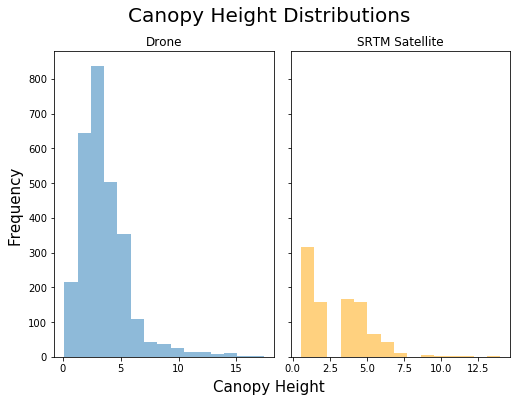

In [71]:
# graph for comparing drone and srtm canopy heights
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharey=True, tight_layout=True)
graph = pd.DataFrame()
graph['drone'] = drone_mean
graph['srtm'] = srtm_mean
# titles
fig.suptitle('Canopy Height Distributions', fontsize=20, y=1.05)
fig.text(-0.02, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=15)
fig.text(0.5, -0.02, 'Canopy Height', ha='center', fontsize=15)
# plot
ax[0].hist(graph['drone'], bins=15, alpha=0.5)
ax[0].title.set_text('Drone')
ax[1].hist(graph['srtm'], bins=15, alpha=0.5, color='orange')
ax[1].title.set_text('SRTM Satellite')
plt.tight_layout()
plt.savefig('/data/mangrove-data/Kathy/biomass_project/results/data/CH_hist.png')

In [135]:
print(np.median(srtm_mean))
print(np.median(drone_mean))
print(stats.mode(drone_mean))
print(stats.mode(srtm_mean))

2.1507999897003174
3.1115848919041023
ModeResult(mode=array([0.06321548]), count=array([1]))
ModeResult(mode=array([1.07539999]), count=array([273]))


In [24]:
# make dataframe
col = ['site_name', 'srtm_biomass', 'drone_biomass', 'biomass_difference', 'srtm_area', 
      'drone_area', 'area_difference']
results = pd.DataFrame(columns=col)
results.site_name = site_names
results.srtm_biomass = all_srtm
results.drone_biomass = all_drone
results.biomass_difference = results.srtm_biomass - results.drone_biomass
results.srtm_area = srtm_ext
results.drone_area = drone_ext
results.area_difference = results.srtm_area - results.drone_area
results.to_csv("/data/mangrove-data/Kathy/biomass_project/results/data/sites_results.csv")

In [25]:
results = pd.read_csv("/data/mangrove-data/Kathy/biomass_project/results/data/sites_results.csv")

In [8]:
# normalization test
x = results.drone_biomass
norm_drone = (x-min(x))/(max(x)-min(x))
y = results.srtm_biomass
norm_srtm = (y-min(y))/(max(y)-min(y))

In [26]:
results

,Unnamed: 0,site_name,srtm_biomass,drone_biomass,biomass_difference,srtm_area,drone_area,area_difference
0,0,lap-2018-07-site6,97.075211,191.648483,-94.573273,3.51,3.080333,0.429667
1,1,lap_07-18_site1,223.246948,919.522949,-696.276001,14.94,14.570173,0.369827
2,2,lap_07-18_site4,79.043510,119.669525,-40.626015,3.78,1.990308,1.789692
3,3,psc_05-18_site3,42.167847,580.295044,-538.127197,4.50,7.596837,-3.096837
4,4,psc_05-18_site4,42.167847,347.783417,-305.615570,4.50,4.239481,0.260519
5,5,psc_07-18_site8,177.555893,2369.260498,-2191.704605,24.93,31.643542,-6.713542
6,6,psc_05-18_site11,141.479279,3026.377197,-2884.897919,33.39,39.327916,-5.937916
7,7,psc_05-18_site1314,65.959564,1115.510620,-1049.551056,7.92,13.985034,-6.065034
8,8,psc_05-18_site12,0.332098,280.935791,-280.603693,0.45,3.886937,-3.436937
9,9,psc_07-18_site11,89.634758,1552.152100,-1462.517342,13.77,18.923046,-5.153046


In [27]:
print("total estimated biomass (Mg/ha) by SRTM: ", np.sum(results.srtm_biomass))
print("total estimated biomass (Mg/ha) by drones: ", np.sum(results.drone_biomass))

total estimated biomass (Mg/ha) by SRTM:  1083.0288367271423
total estimated biomass (Mg/ha) by drones:  10804.041244506836


In [115]:
print("total estimated area (ha) by SRTM: ", np.sum(results.srtm_area))
print("total estimated area (ha) by drones: ", np.sum(results.drone_area))

total estimated area (ha) by SRTM:  115.64999999999999
total estimated area (ha) by drones:  142.8415149317026


In [124]:
total_drone = np.sum(results.drone_biomass)*np.sum(results.drone_area)
total_srtm = np.sum(results.srtm_biomass)*np.sum(results.srtm_area)
print("total estimated biomass (Mg) by SRTM: ", total_srtm)
print("total estimated biomass (Mg) by drones: ", total_drone)
print("factor difference: ", total_drone/total_srtm)

total estimated biomass (Mg) by SRTM:  125252.28496749401
total estimated biomass (Mg) by drones:  1543265.6187499538
factor difference:  12.3212572062096


In [128]:
mexico = 26388806
print("% total SRTM of total SRTM in Mexico: ", (total_srtm/mexico)*100)
print("% total drone of total SRTM in Mexico: ", (total_drone/mexico)*100)

% total SRTM of total SRTM in Mexico:  0.474641728646207
% total drone of total SRTM in Mexico:  5.8481828194498595


Text(0, 0.5, 'SRTM Biomass (Mg)')

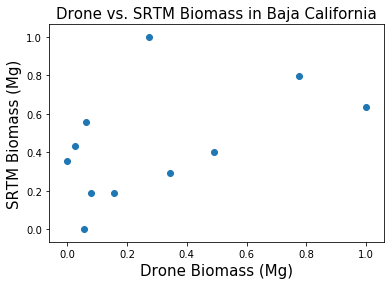

In [10]:
# plot difference
# x = results.drone_biomass
# y = results.srtm_biomass
plt.scatter(norm_drone,norm_srtm, marker='o')
plt.title("Drone vs. SRTM Biomass in Baja California", size=15)
plt.xlabel("Drone Biomass (Mg)", size=15)
plt.ylabel("SRTM Biomass (Mg)", size=15)

In [13]:
# independent 2 sample t-test
drone = list(results.drone_biomass)
srtm = list(results.srtm_biomass)
print("Drone variance: ", np.var(drone))
print("SRTM variance: ", np.var(srtm))
stats.ttest_ind(drone,srtm, equal_var = False)

Drone variance:  848913.2779309484
SRTM variance:  3802.6813604869226


Ttest_indResult(statistic=3.0263323250086924, pvalue=0.01263414962567396)

In [28]:
# list of site names
site_names = ["lap-2018-07-site6", "lap_07-18_site1", "lap_07-18_site4", "psc_05-18_site3", 
              "psc_05-18_site4", "psc_07-18_site8", "psc_05-18_site11", "psc_05-18_site1314", "psc_05-18_site12", 
              "psc_07-18_site11", "lap_07-18_site5"]
biomass = []
for site in site_names:
    basedir = f'/data/mangrove-data/Kathy/biomass_project/downsampling/{site}/biomass/scaled_down_0.tif'
    if os.path.isfile(basedir):
        biomass.append(basedir)


from zipfile import ZipFile
# Create a ZipFile Object
with ZipFile('/data/mangrove-data/Kathy/biomass_project/downsampling/all_biomass.zip', 'w') as zipObj2:
   # Add multiple files to the zip
    for site in biomass:
        zipObj2.write(site)
        print(site)

# # convert list to string
# biomass_str = ' '.join([str(elem) for elem in biomass]) 
# # call to merge
# call = f'gdal_merge.py -ot Float32 -of GTiff -n {nodata} -o /data/mangrove-data/Kathy/biomass_project/downsampling/all_biomass.tif {biomass_str}'
# print(subprocess.run(call, shell=True))